In [1]:
%matplotlib notebook

import numpy as np
import scipy.io
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output, display
from scipy.ndimage import gaussian_filter
from scipy.spatial import distance
from sklearn.cluster import KMeans
import multiprocessing
from functools import partial
import time
import os
from os.path import join
import re

import wolff
import wolff_cross

# Track calculation errors
np.seterr('raise')

mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14

In [2]:
start_path = '/Users/share/Chiel4Loran/FFxRECxNOISE'
pat_neuro = re.compile(r"neuro_mem")

neuro_prefix = "neuro_mem"
angle_prefix = "initial_angles"

files = []
params = []

for (dirpath, dirnames, filenames) in os.walk(start_path):
    neuro_files = list(filter(pat_neuro.match, filenames))
    _params = [pat_neuro.sub("", file) for file in neuro_files]
    files += [(join(dirpath, neuro_prefix+param), join(dirpath, angle_prefix+param)) for param in _params]
    params += _params
    
params = [re.sub(r"(^_)|(\.npy)", "", param) for param in params]
params_txt = [re.sub(r"_", " ", param) for param in params]
params_txt = [re.sub(r",", ".", param) for param in params_txt]

In [3]:
# Group the thousands of neurons into a handful of channels 
def group(mem_data):
    cut_data = mem_data[:, :500, :] # trials by 500 by neurons
    num_channels = 17
    neurons = np.mean(cut_data, 1).T # neurons by trials
    kmeans = KMeans(n_clusters=num_channels, n_init=20, n_jobs=10, tol=1e-20).fit(neurons)
    
    data = np.empty((mem_data.shape[0], num_channels, mem_data.shape[1])) # trials by num_channels by timesteps
    for channel in range(num_channels):
        print(str(channel + 1) + "/" + str(num_channels), end='\r')
        data[:, channel, :] = np.mean(mem_data[:, :, kmeans.labels_ == channel], axis=2)
    
    return data

In [4]:
paths_prepared = []

for (dat_file, ang_file), param in zip(files, params):
    print("Preparing for " + param)
    path = join('/Users/s3182541/STSP/Decoding/data/FFxRECxNOISE', param)
    paths_prepared.append(path)
    
    if not os.path.exists(path):
        # Load raw data and angles
        data_raw = np.load(dat_file)
        angles = np.load(ang_file)

        # Prepare data and transform angles
        data = group(data_raw)
        data += np.random.normal(scale=0.5, size=data.shape) # Prevent division by zero errors
        angles = angles / 360 * 2 * np.pi # Convert to radians
        angles = angles * 2 # 'Scale' angles

        if __name__ == '__main__':
            sigma = wolff_cross.prepare_sigma(data)

        # Save all of it to file
        if not os.path.exists(path):
            os.mkdir(path)

        np.save(join(path, "data.npy"), data)
        np.save(join(path, "angles.npy"), angles)
        np.save(join(path, "sigma.npy"), sigma)

Preparing for 1,5x0,45n0,008
Preparing for 1,75x0,30n0,016
Preparing for 1,25x0,60n0,012
Preparing for 1x0,75n0,030
Preparing for 1,75x0,45n0,016
Preparing for 1,25x0,60n0,004
Preparing for 1x0,75n0,004
Preparing for 1,75x0,30n0,008
Preparing for 1,5x0,45n0,016
Preparing for 1x0,75n0,012
Preparing for 1,75x0,45n0,008
Preparing for 1,25x0,60n0,030
Preparing for 1,75x0,45n0,030
Preparing for 1,25x0,60n0,008
Preparing for 1,5x0,45n0,012
Preparing for 1x0,75n0,016
Preparing for 1,75x0,30n0,030
Preparing for 1,5x0,45n0,004
Preparing for 1,75x0,45n0,004
Preparing for 1,75x0,30n0,004
Preparing for 1,75x0,30n0,012
Preparing for 1,25x0,60n0,016
Preparing for 1,5x0,45n0,030
Preparing for 1,75x0,45n0,012
Preparing for 1x0,75n0,008


In [5]:
files, params, params_txt, paths_prepared = zip(*sorted(zip(
    files, 
    params, 
    params_txt, 
    paths_prepared), key=lambda tup: tup[3]))

In [8]:
# Start four processes
# Define a function that:
#  uses a path to read in data 
#  starts the decoding
#  writes the result to disk

def decode_file(path_tup):
    i, path = path_tup
    
    print("Starting with " + path)
    
    if not os.path.exists(join(path, "c.npy")):
        data = np.load(join(path, "data.npy"))
        angles = np.load(join(path, "angles.npy"))
        sigma = np.load(join(path, "sigma.npy"))

        bin_width = np.pi / 6

        device_i = i % 4
#         device_i = 0
    
        cross_cos_amp = wolff_cross.cross_decode(data, angles, bin_width, sigma, device_i)
        c = np.mean(cross_cos_amp, 0)

        np.save(join(path, "c.npy"), c)
    
    print("Done with " + path)

if __name__ == '__main__':
    with multiprocessing.Pool(4) as pool:
        calcs = pool.imap(decode_file, enumerate(paths_prepared))
        for i, path in enumerate(paths_prepared):
            next(calcs)

Starting with /Users/s3182541/STSP/Decoding/data/low_res/model4_lowres
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Trial 1/360
Trial 2/360
Trial 3/360
Trial 4/360
Trial 5/360
Trial 6/360
Trial 7/360
Trial 8/360
Trial 9/360
Trial 10/360
Trial 11/360
Trial 12/360
Trial 13/360
Trial 14/360
Trial 15/360
Trial 16/360
Trial 17/360
Trial 18/360
Trial 19/360
Trial 20/360
Trial 21/360
Trial 22/360
Trial 23/360
Trial 24/360
Trial 25/360
Trial 26/360
Trial 27/360
Trial 28/360
Trial 29/360
Trial 30/360
Trial 31/360
Trial 32/360
Trial 33/360
Trial 34/360
Trial 35/360
Trial 36/360
Trial 37/360
Trial 38/360
Trial 39/360
Trial 40/360
Trial 41/360
Trial 42/360
Trial 43/360
Trial 44/360
Trial 45/360
Trial 46/360
Trial 47/360
Trial 48/360
Trial 49/360
Trial 50/360
Trial 51/360
Trial 52/360
Trial 53/360
Trial 54/360
Trial 55/360
Trial 56/360
Trial 57/360
Trial 58/360
Trial 59/360
Trial 60/360
Trial 61/360
Trial 62/360
Trial 63/360
Trial 64/360
Trial 65/360
Trial 66/360
Trial 67/360
Trial 68/3

<IPython.core.display.Javascript object>


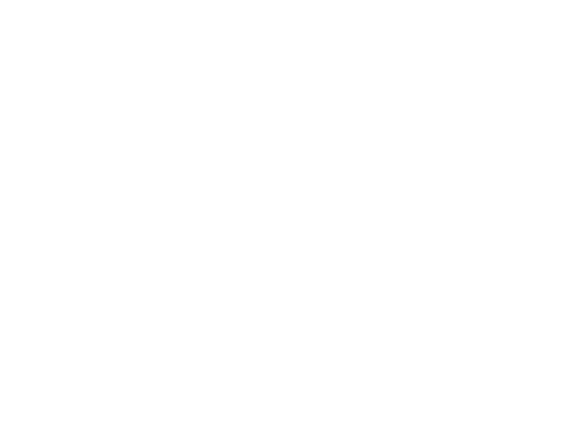

<IPython.core.display.Javascript object>


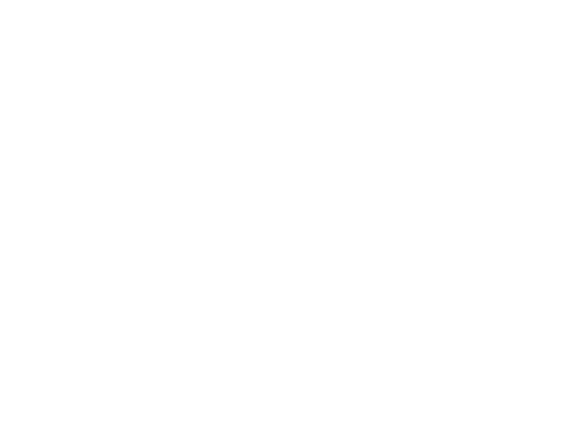

<IPython.core.display.Javascript object>


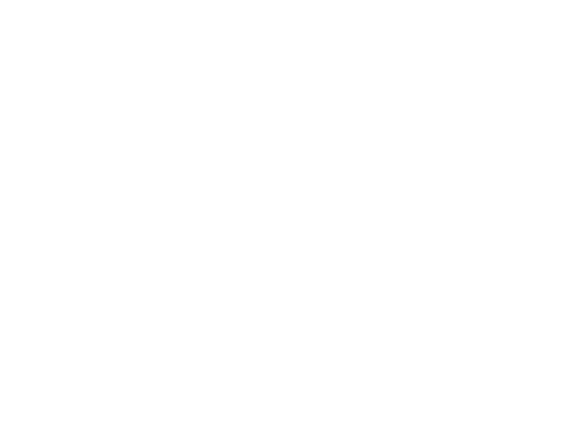

<IPython.core.display.Javascript object>


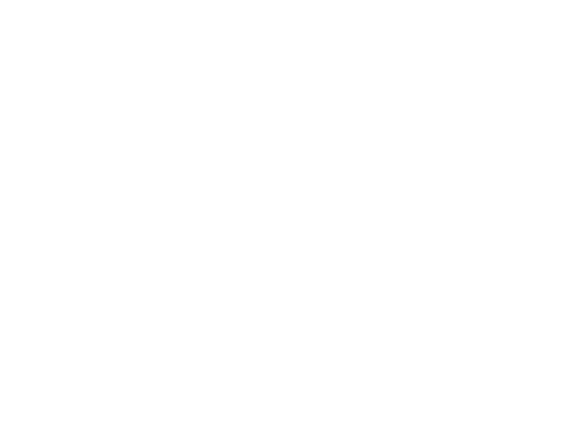

<IPython.core.display.Javascript object>


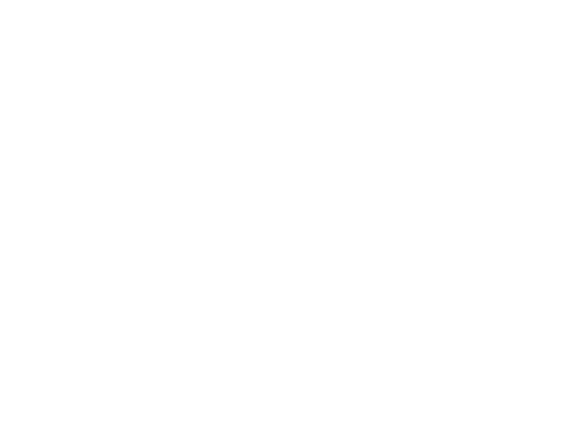

<IPython.core.display.Javascript object>


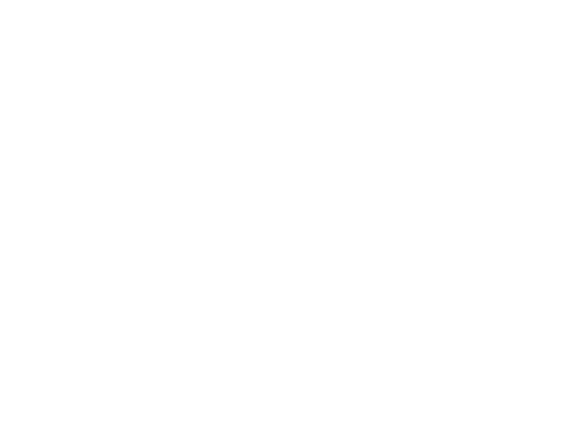

<IPython.core.display.Javascript object>


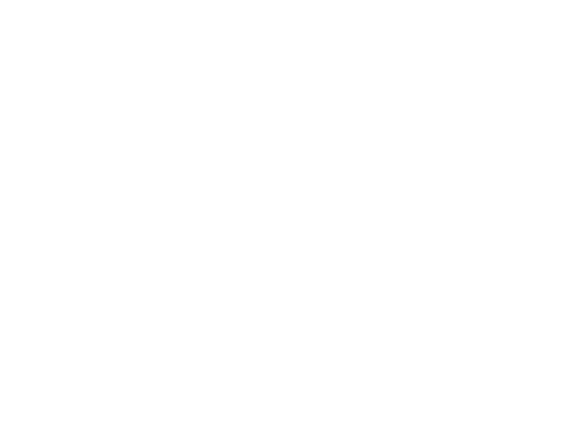

<IPython.core.display.Javascript object>


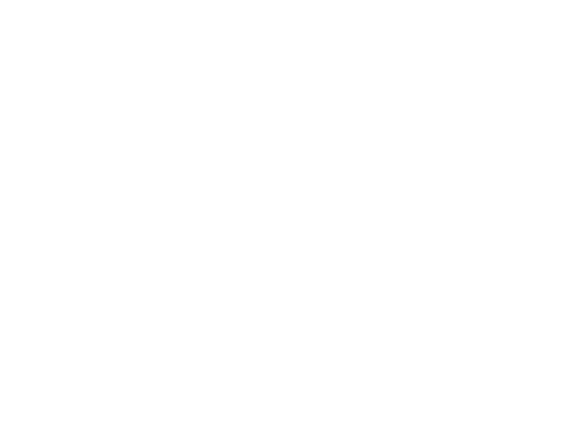

<IPython.core.display.Javascript object>


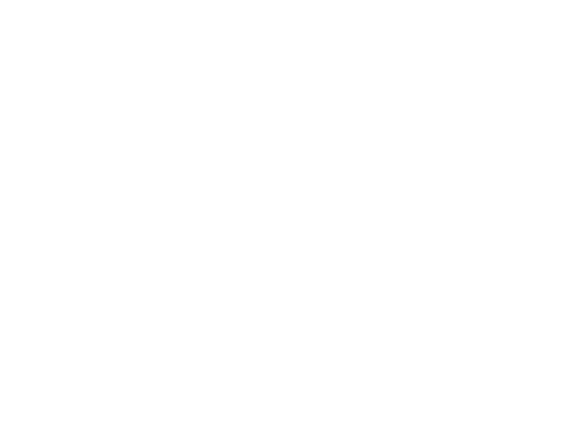

<IPython.core.display.Javascript object>


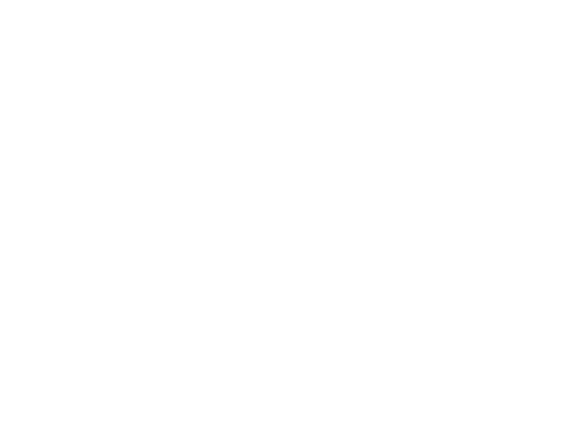

<IPython.core.display.Javascript object>


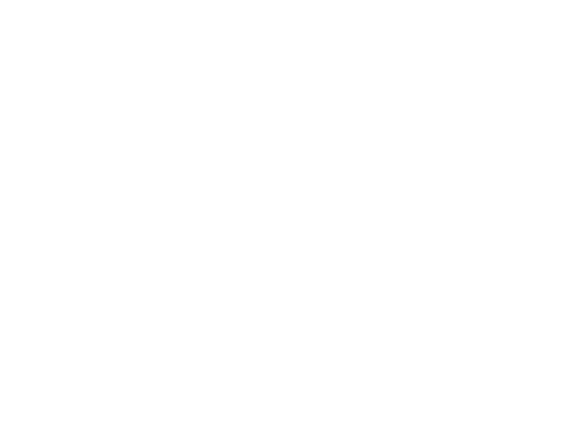

<IPython.core.display.Javascript object>


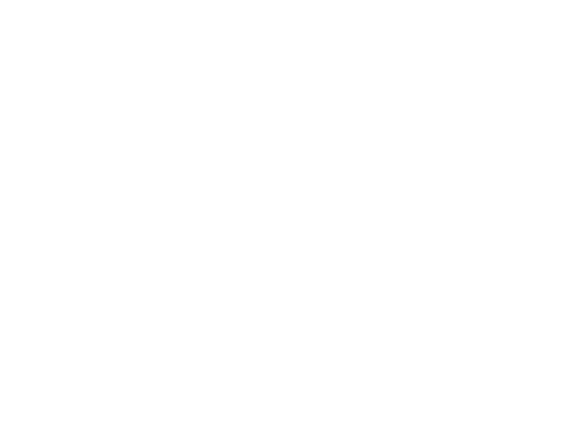

<IPython.core.display.Javascript object>


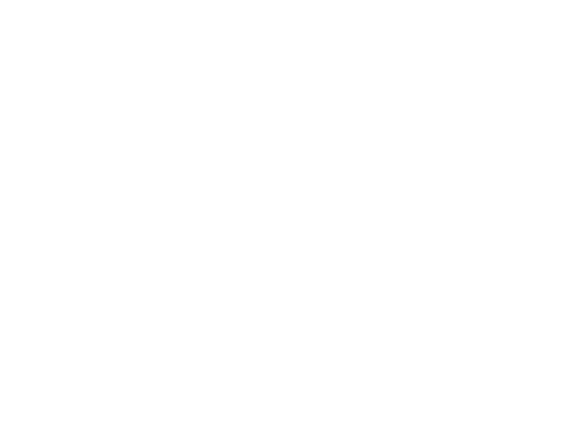

<IPython.core.display.Javascript object>


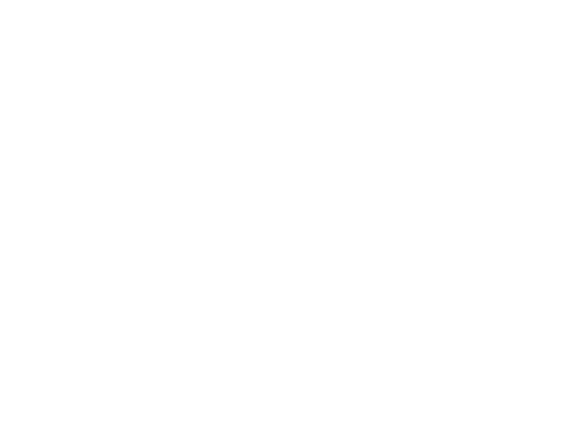

<IPython.core.display.Javascript object>


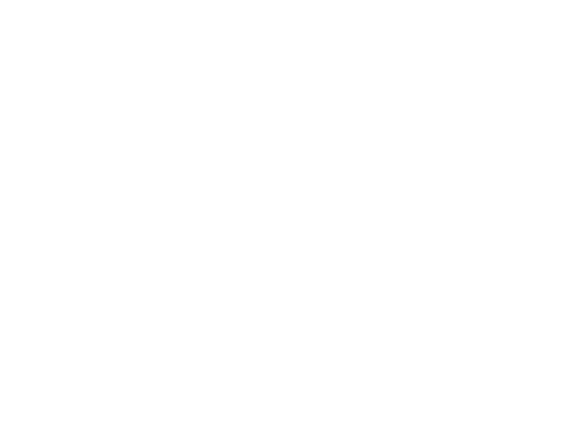

<IPython.core.display.Javascript object>


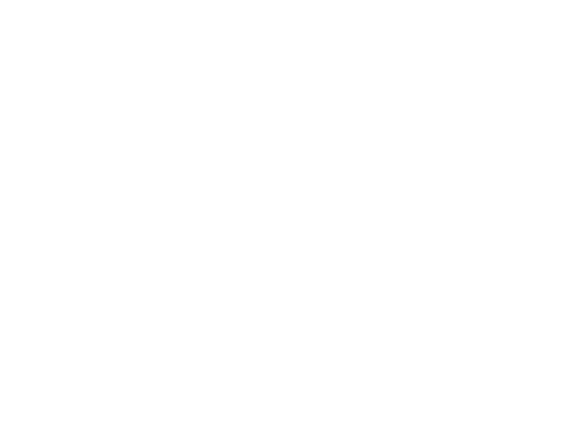

<IPython.core.display.Javascript object>


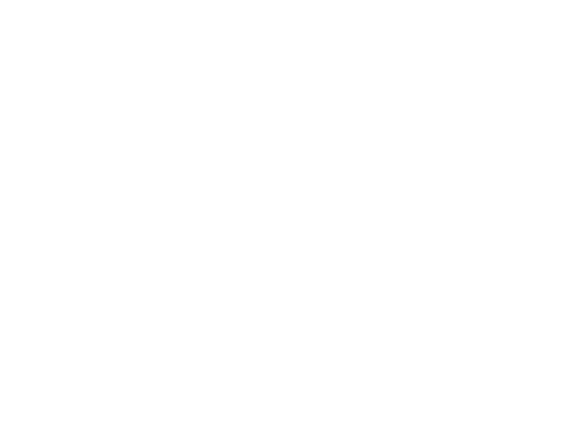

<IPython.core.display.Javascript object>


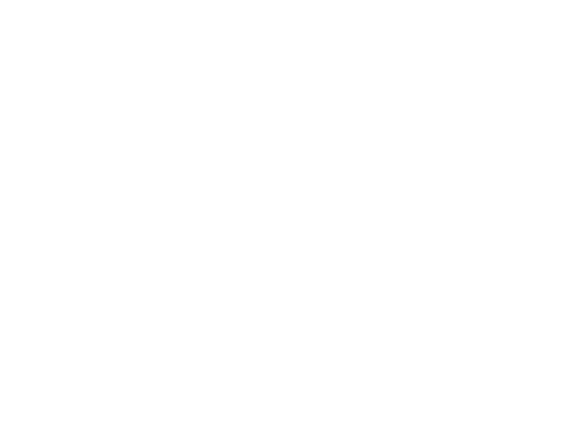

<IPython.core.display.Javascript object>


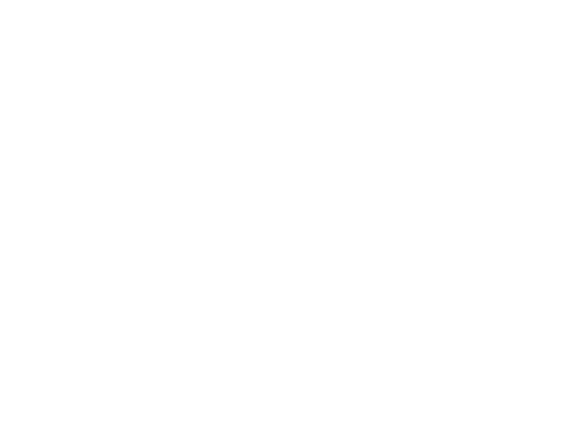

<IPython.core.display.Javascript object>


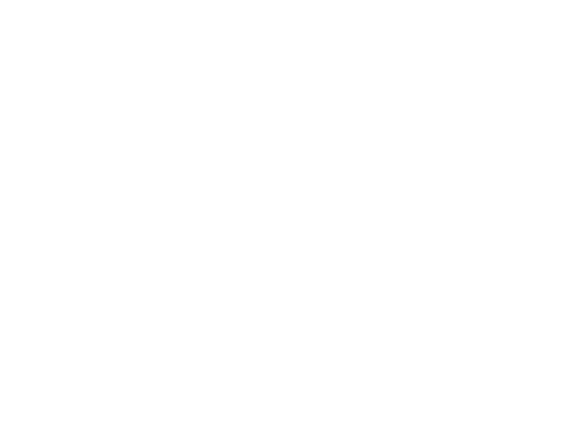

<IPython.core.display.Javascript object>


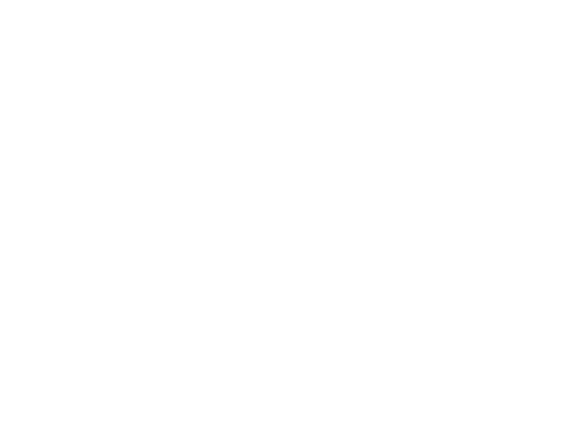

<IPython.core.display.Javascript object>


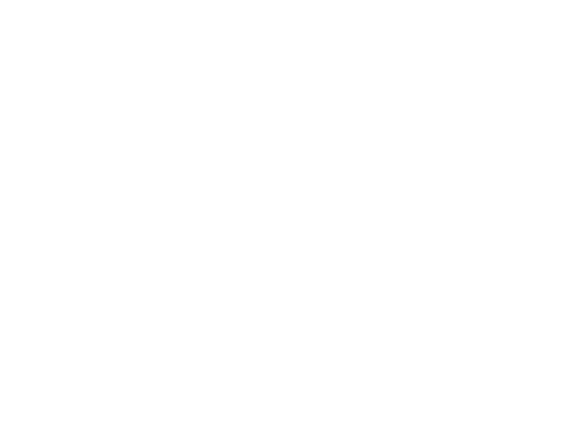

<IPython.core.display.Javascript object>


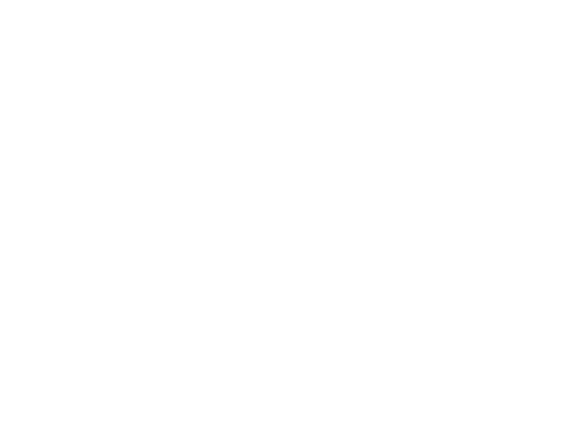

<IPython.core.display.Javascript object>


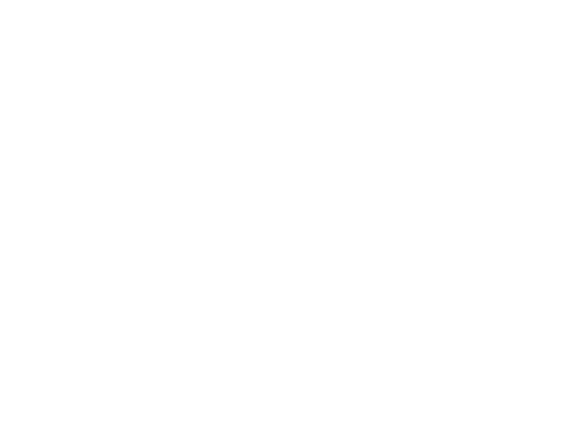

<IPython.core.display.Javascript object>


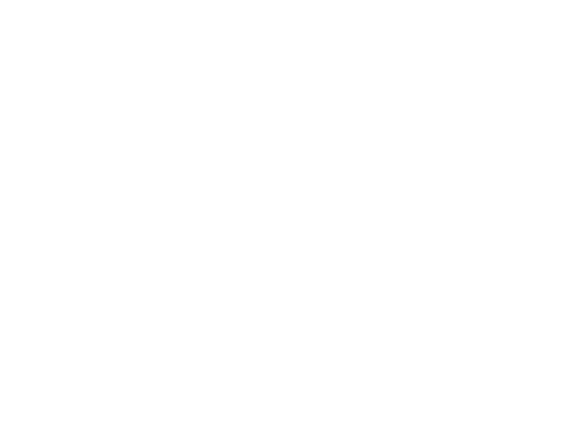

<IPython.core.display.Javascript object>


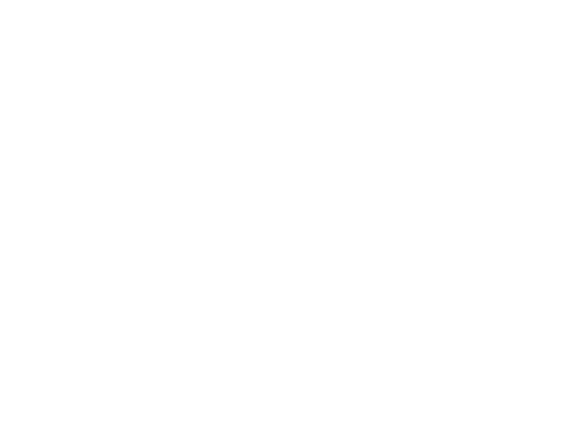

<IPython.core.display.Javascript object>


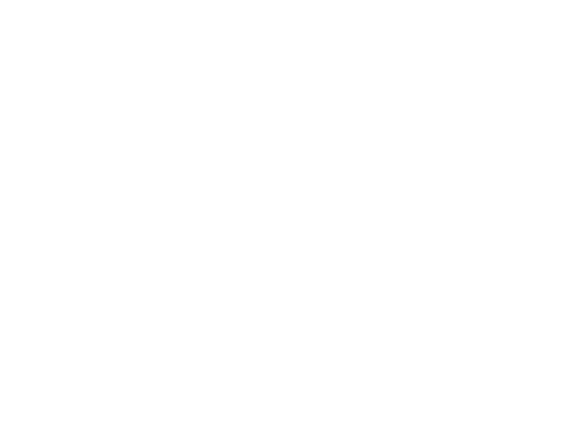

<IPython.core.display.Javascript object>


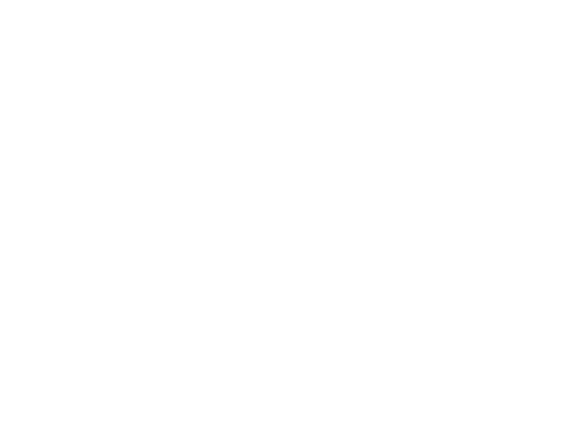

<IPython.core.display.Javascript object>


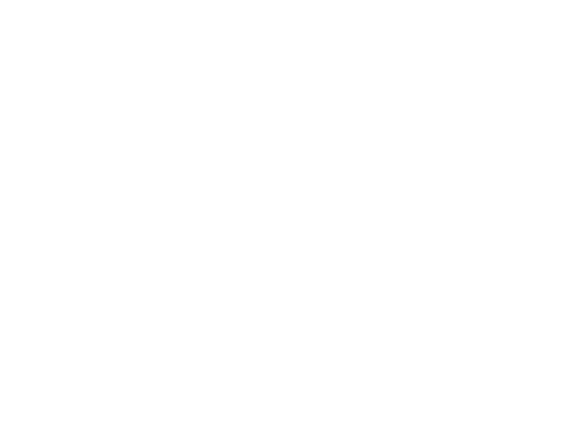

<IPython.core.display.Javascript object>


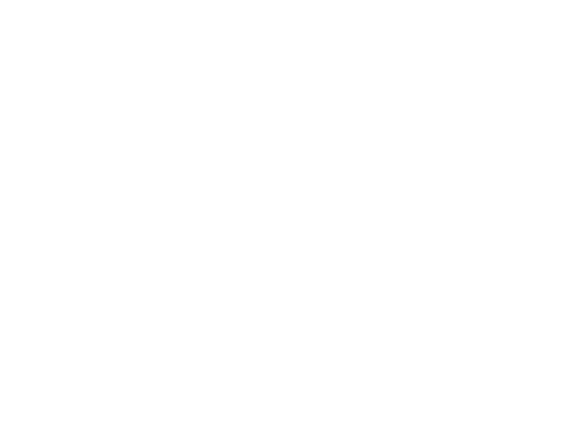

<IPython.core.display.Javascript object>


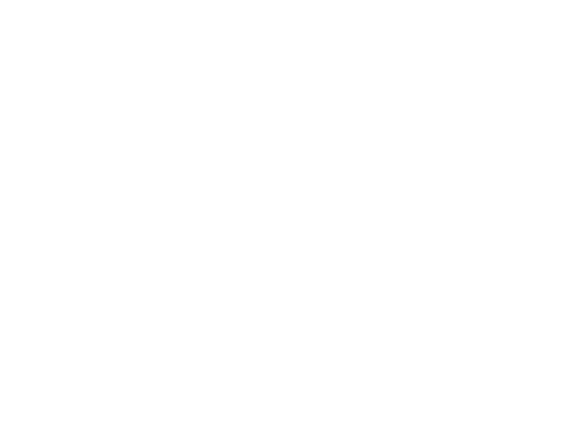

<IPython.core.display.Javascript object>


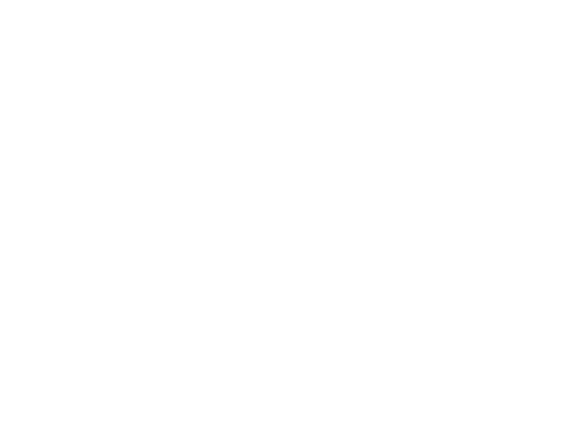

<IPython.core.display.Javascript object>


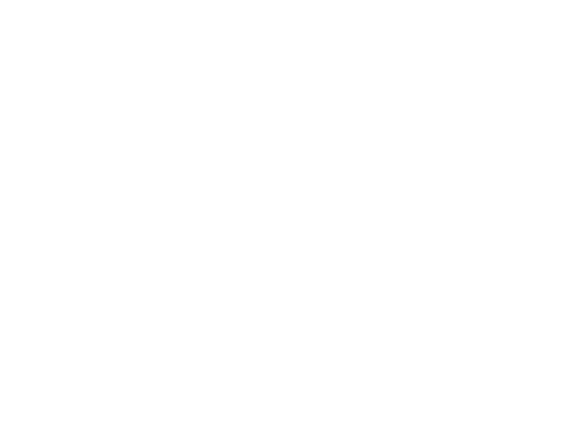

<IPython.core.display.Javascript object>


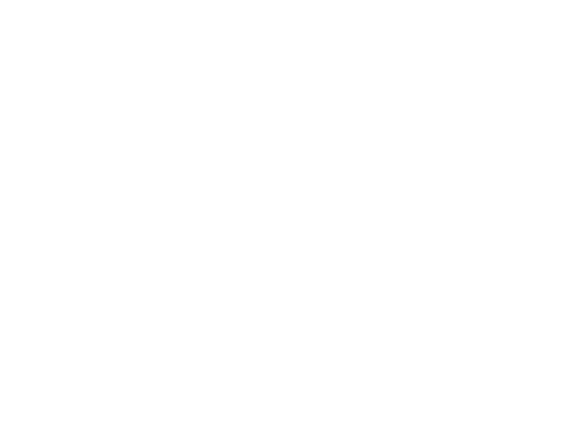

<IPython.core.display.Javascript object>


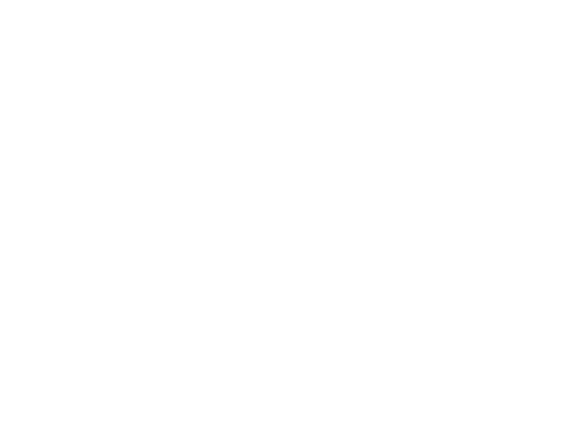

<IPython.core.display.Javascript object>


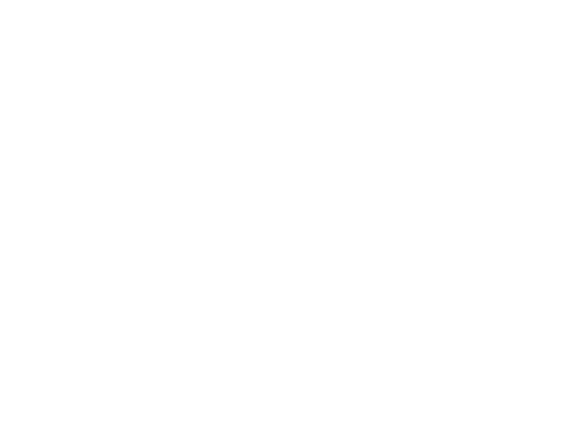

<IPython.core.display.Javascript object>


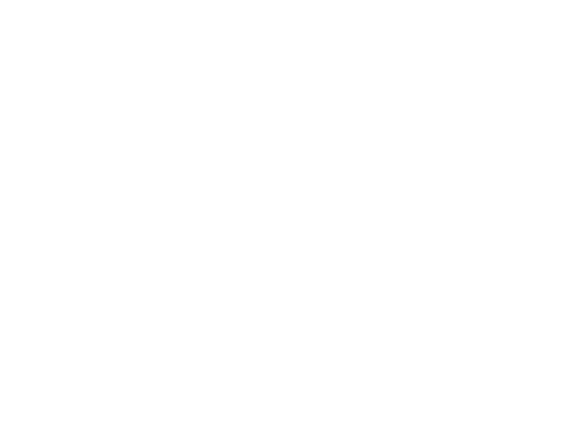

<IPython.core.display.Javascript object>


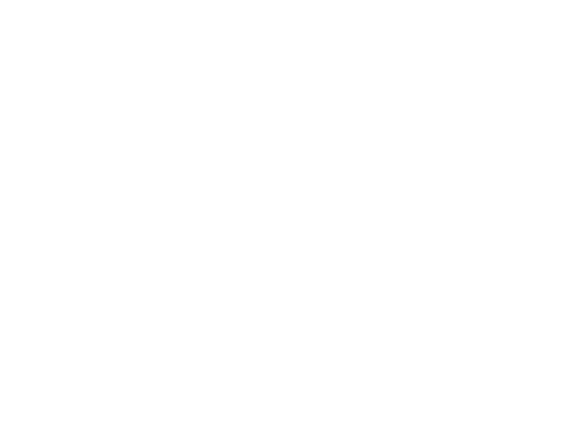

<IPython.core.display.Javascript object>


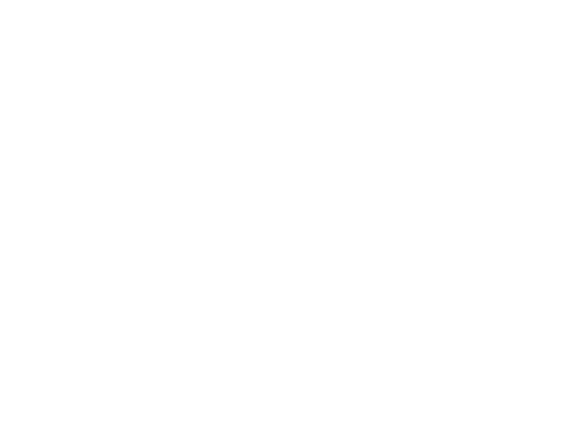

<IPython.core.display.Javascript object>


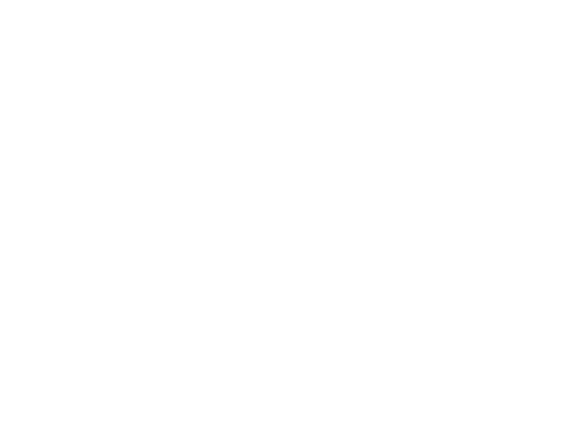

<IPython.core.display.Javascript object>


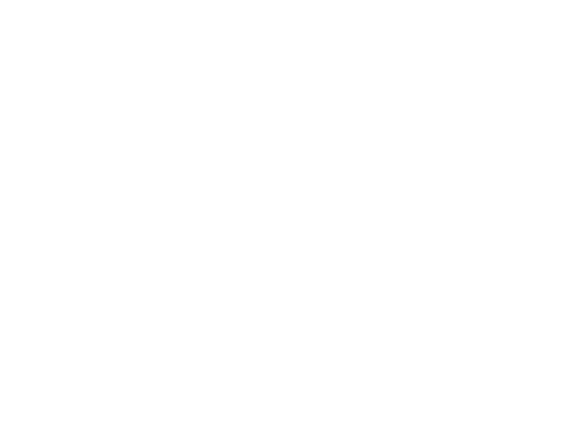

<IPython.core.display.Javascript object>


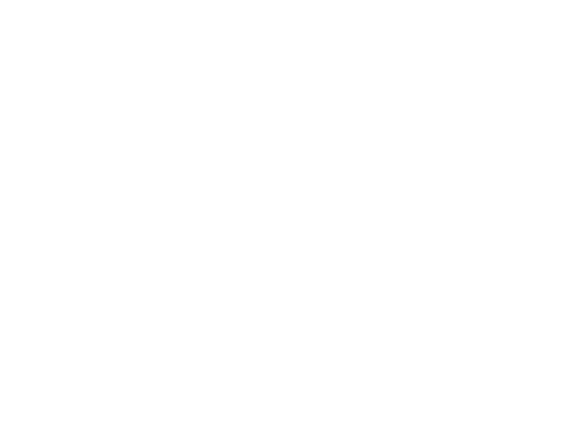

<IPython.core.display.Javascript object>


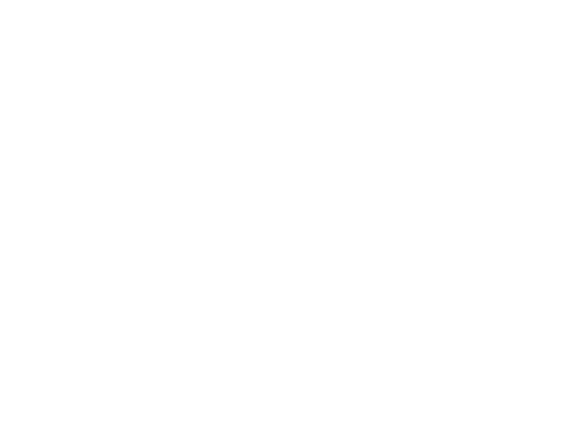

<IPython.core.display.Javascript object>


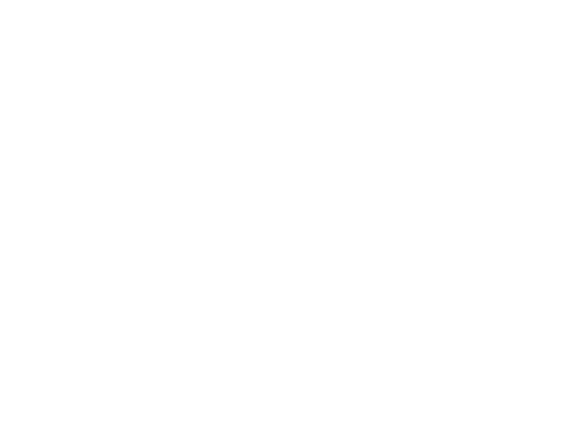

<IPython.core.display.Javascript object>


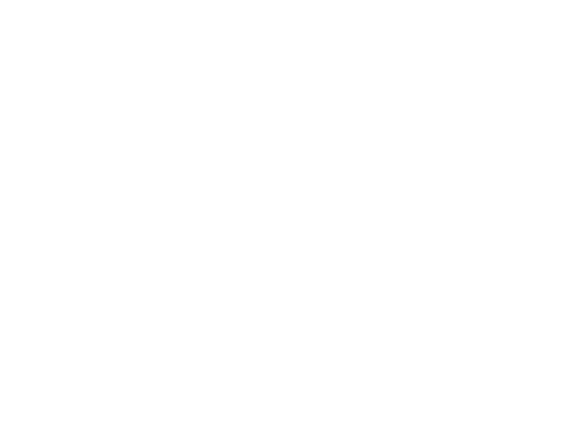

<IPython.core.display.Javascript object>


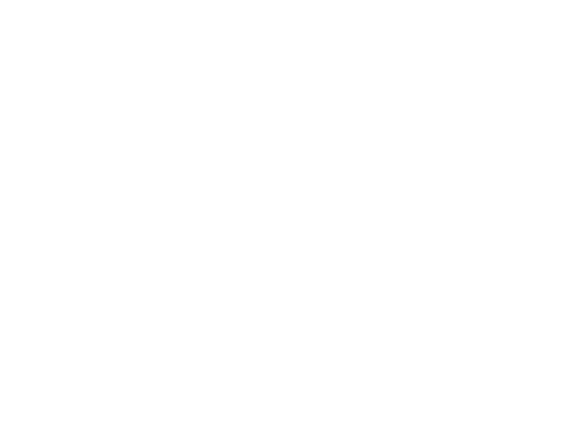

<IPython.core.display.Javascript object>


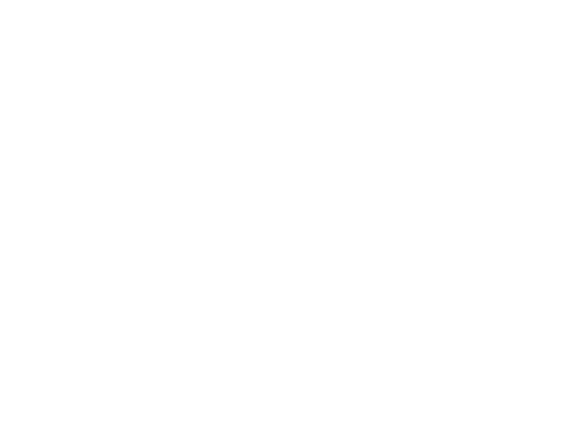

<IPython.core.display.Javascript object>


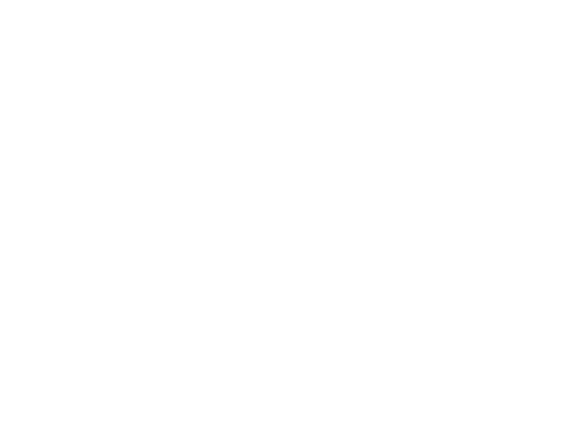

<IPython.core.display.Javascript object>


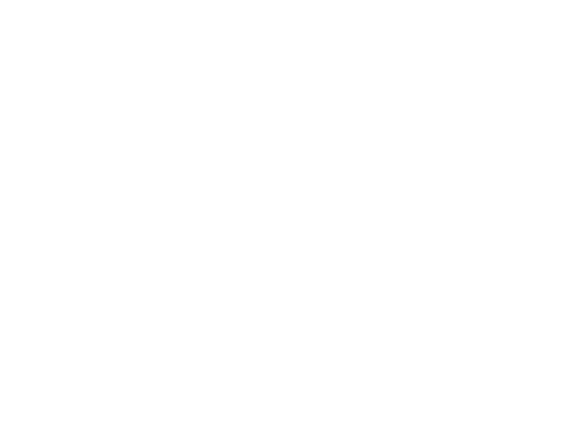

<IPython.core.display.Javascript object>


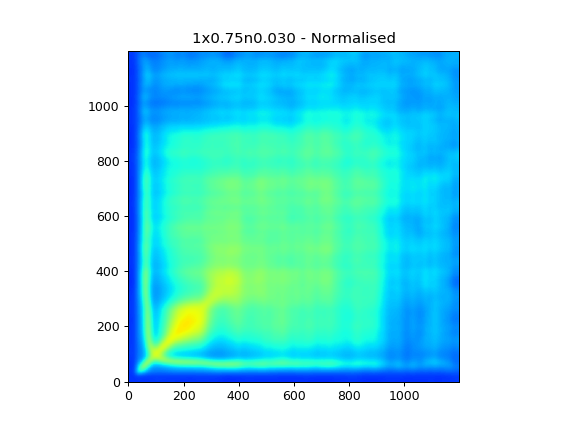

In [6]:
vmin = 0
vmax = 0

for path, param_txt in zip(paths_prepared, params_txt):
    file = join(path, "not-normalised.pdf")

    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)

    vmin = min(vmin, np.min(filtered))
    vmax = max(vmax, np.max(filtered))

    if not os.path.exists(file):
        plt.close()

        plt.title(param_txt + " - Not normalised")
        plt.imshow(filtered, cmap='jet', origin='lower')
        plt.savefig(file, dpi=300, format='pdf')
    
for path, param_txt in zip(paths_prepared, params_txt):
    file = join(path, "normalised.pdf")
    
    if not os.path.exists(file):
        c = np.load(join(path, "c.npy"))
        c_transformed = (c + c.T) / 2
        filtered = gaussian_filter(c_transformed, sigma=8)

        plt.close()

        plt.title(param_txt + " - Normalised")
        plt.imshow(filtered, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
        plt.savefig(file, dpi=300, format='pdf')

<IPython.core.display.Javascript object>


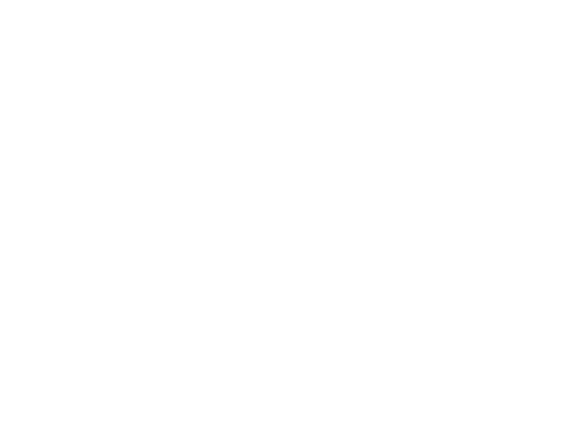

<IPython.core.display.Javascript object>


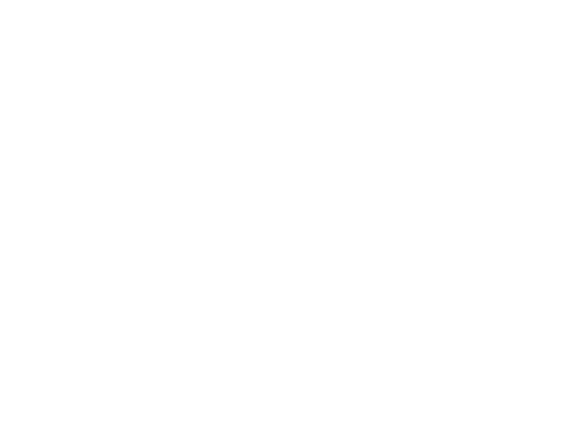

<IPython.core.display.Javascript object>


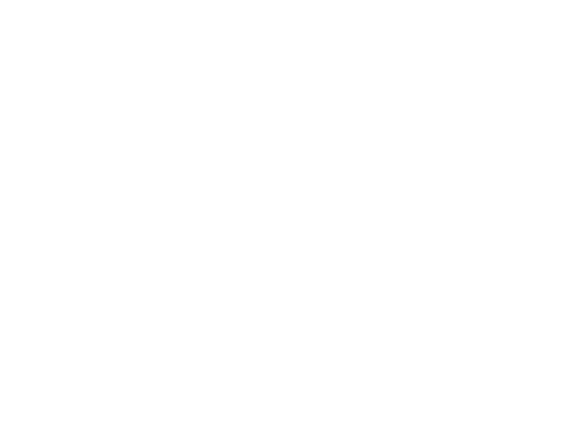

<IPython.core.display.Javascript object>


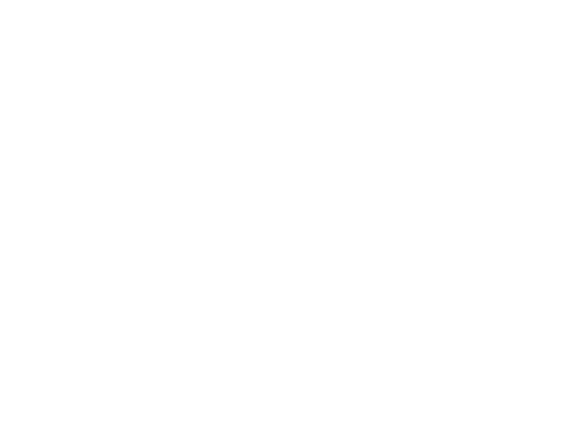

<IPython.core.display.Javascript object>


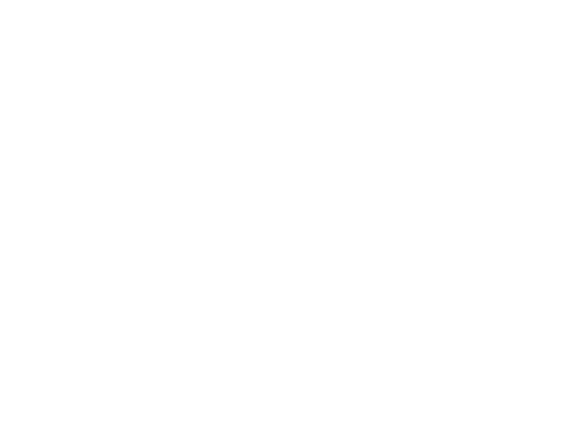

<IPython.core.display.Javascript object>


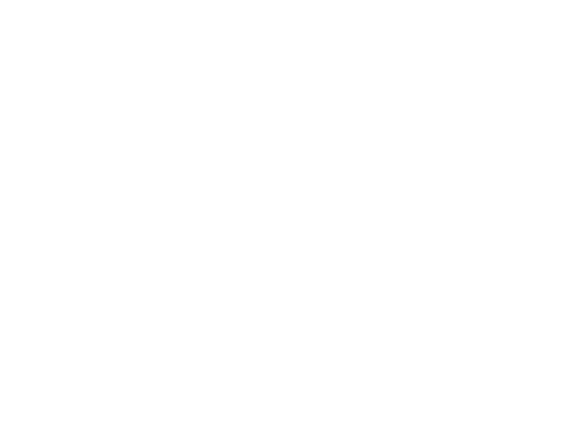

<IPython.core.display.Javascript object>


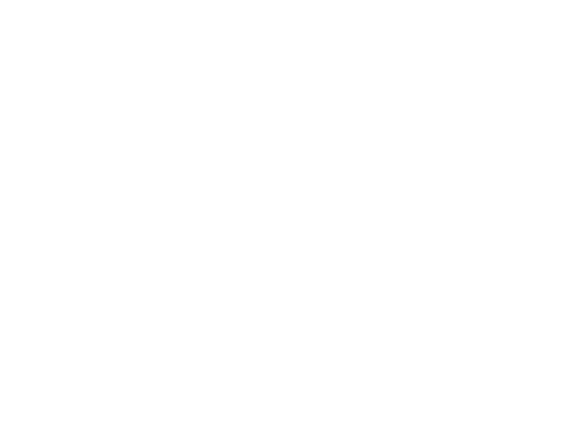

<IPython.core.display.Javascript object>


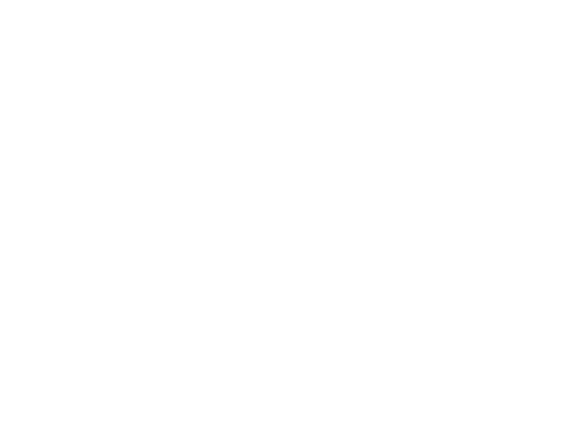

<IPython.core.display.Javascript object>


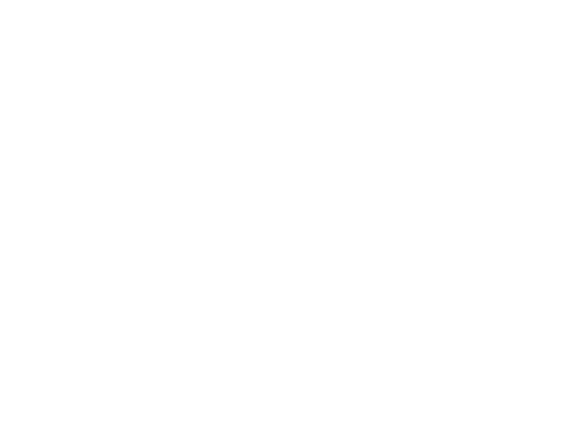

<IPython.core.display.Javascript object>


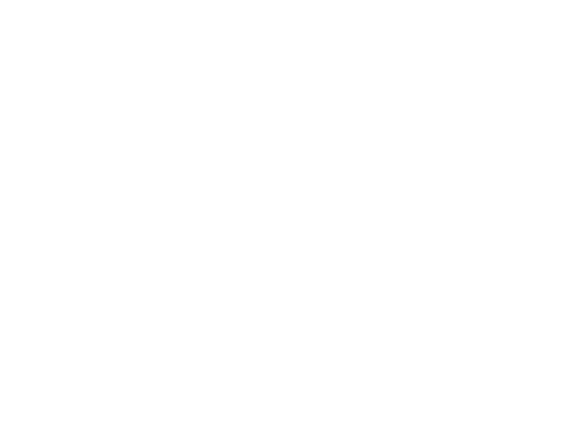

<IPython.core.display.Javascript object>


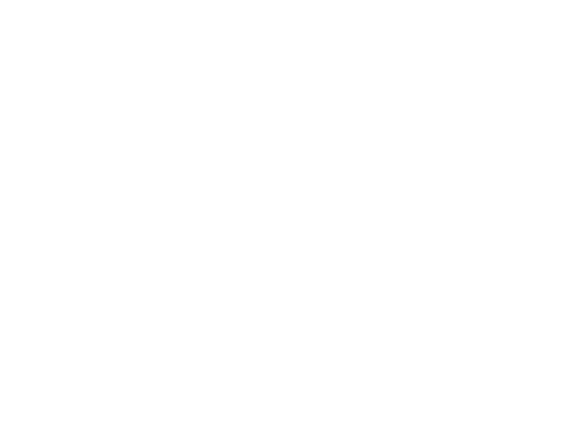

<IPython.core.display.Javascript object>


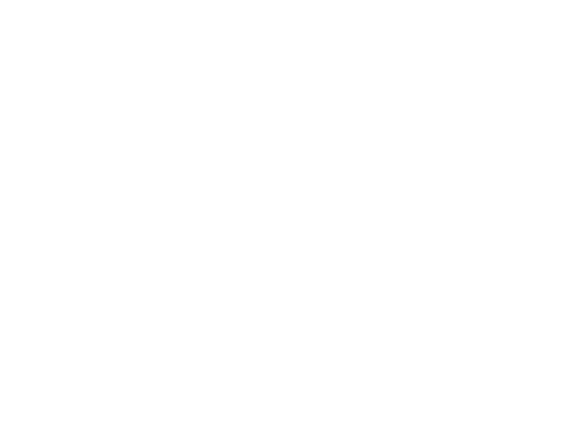

<IPython.core.display.Javascript object>


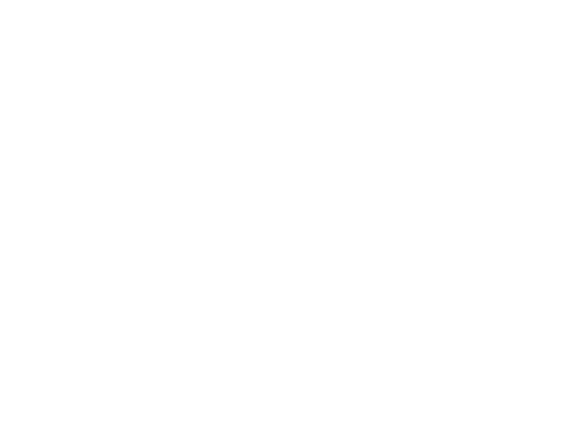

<IPython.core.display.Javascript object>


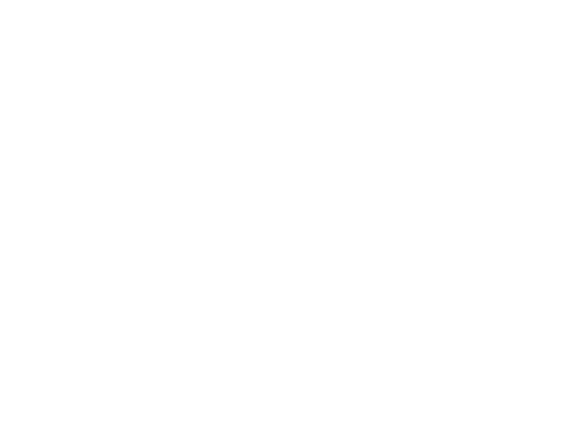

<IPython.core.display.Javascript object>


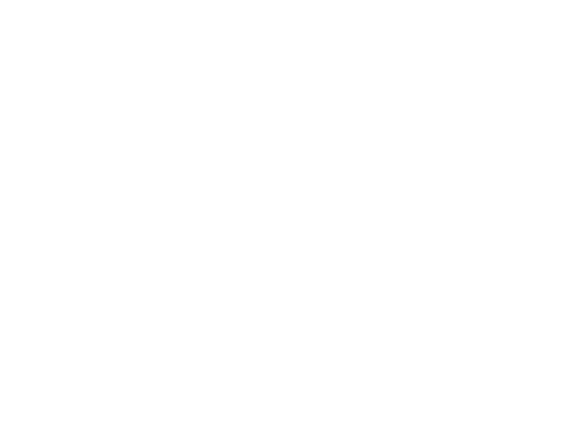

<IPython.core.display.Javascript object>


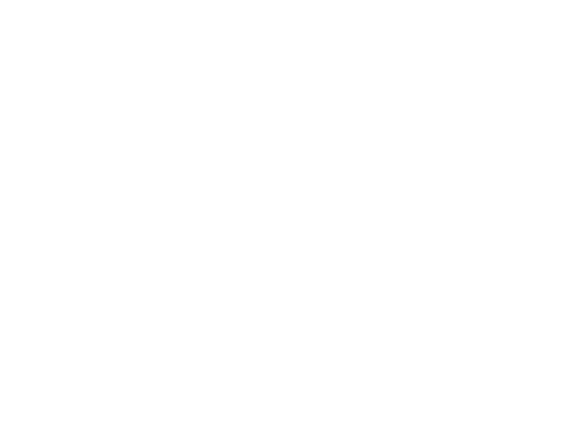

<IPython.core.display.Javascript object>


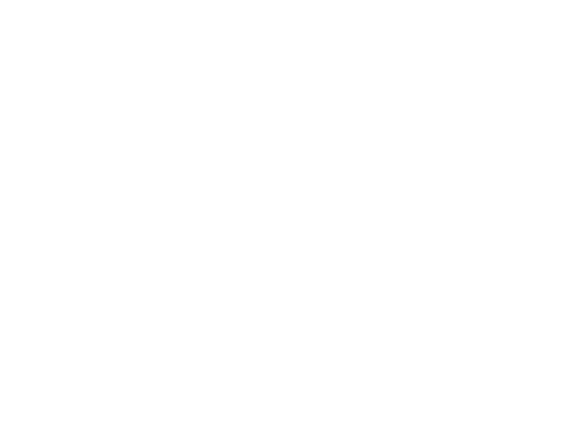

<IPython.core.display.Javascript object>


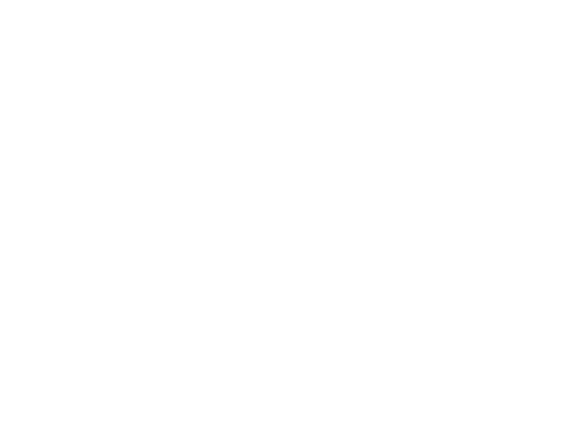

<IPython.core.display.Javascript object>


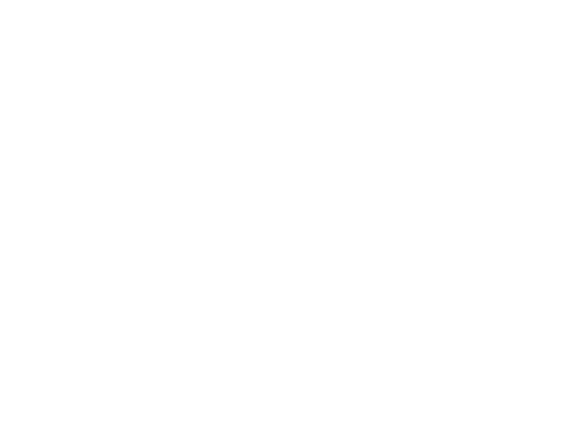

<IPython.core.display.Javascript object>


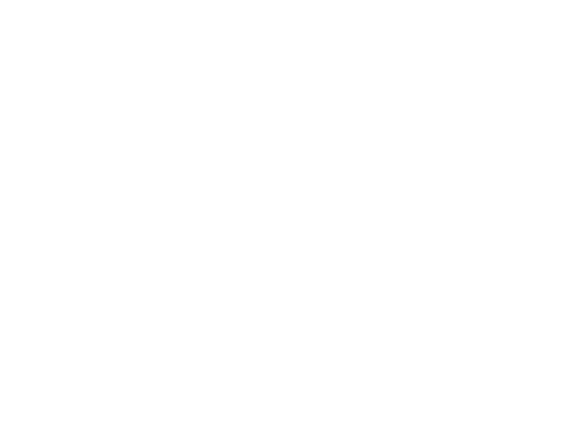

<IPython.core.display.Javascript object>


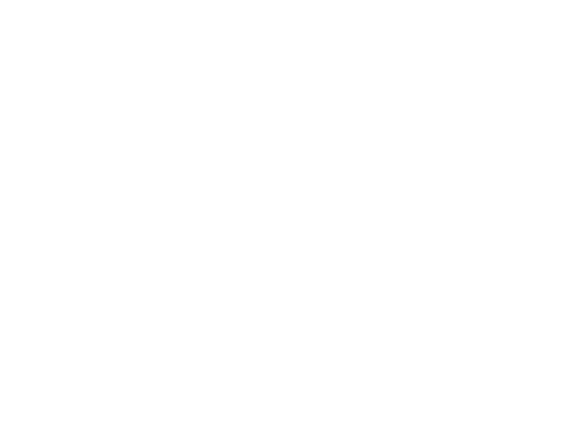

<IPython.core.display.Javascript object>


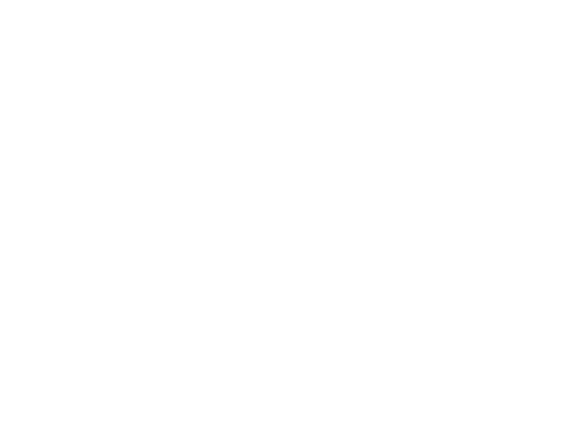

<IPython.core.display.Javascript object>


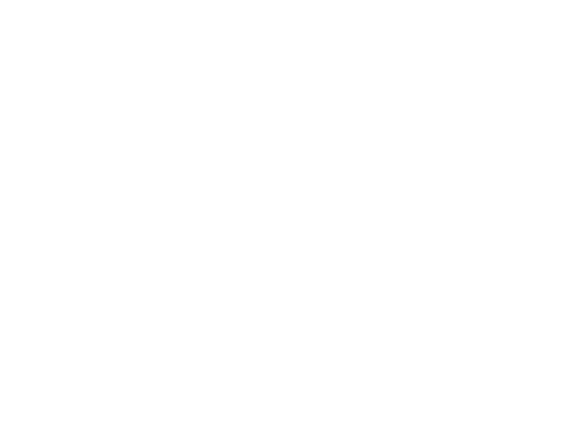

<IPython.core.display.Javascript object>


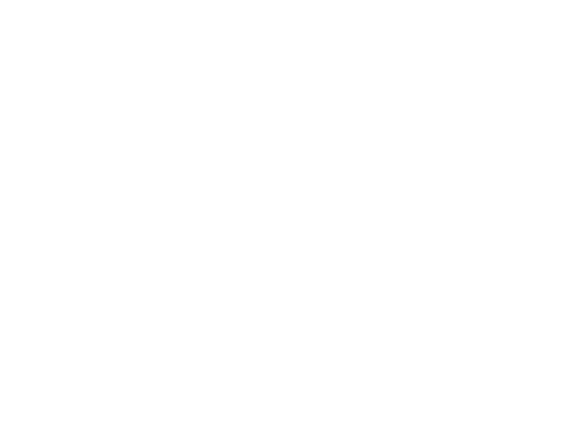

<IPython.core.display.Javascript object>


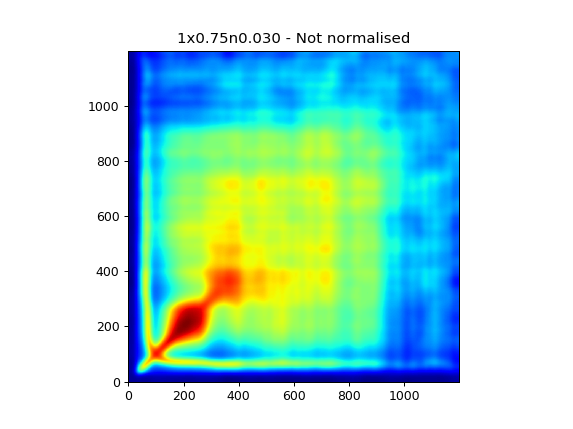

In [7]:
ctda_path = '/Users/s3182541/STSP/Decoding/data/FFxRECxNOISE/ctdas/'
if not os.path.exists(ctda_path):
    os.mkdir(ctda_path)

for path, param, param_txt in zip(paths_prepared, params, params_txt):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)
    
    plt.close()

    plt.title(param_txt + " - Not normalised")
    plt.imshow(filtered, cmap='jet', origin='lower')
    plt.savefig(join(ctda_path, param + ".pdf"), dpi=300, format='pdf')

<IPython.core.display.Javascript object>


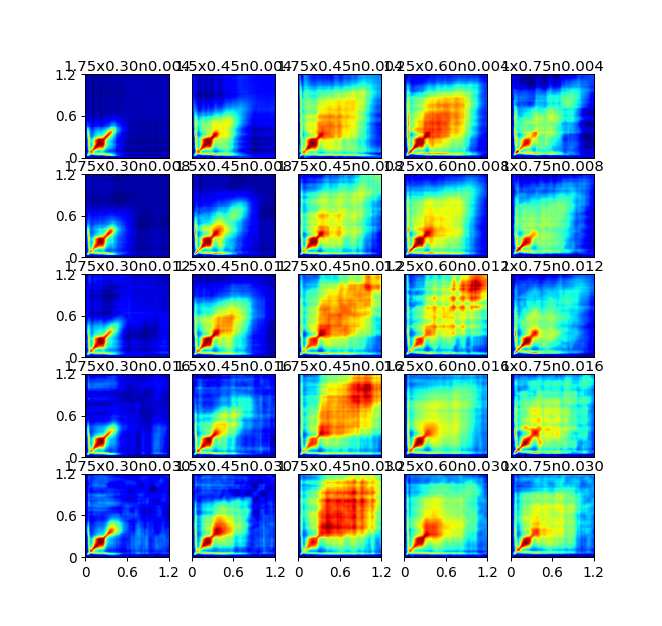

In [25]:
nrow = 5
ncol = 5
left_i = [i for i in range(nrow * ncol) if i % ncol == 0]
bottom_i = list(range(nrow * ncol - ncol, nrow * ncol))
top_i = list(range(ncol))
save_path = '/Users/s3182541/STSP/Decoding/data/FFxRECxNOISE'

tups = np.array(list(zip(paths_prepared, params_txt)))
tups = tups.reshape((5, 5, 2))
tups = tups.transpose((1, 0, 2))
tups = tups[:, [2, 1, 3, 0, 4], :]
tups = tups.reshape((25, 2))

vmin = 0
vmax = 0

plt.close()
fig = plt.figure(figsize=[7.4, 7.0])

for i, (path, param_txt) in enumerate(tups):
#     param_txt = ["1.75x0.30", "1.5x0.45", "1.75x0.45", "1.25x0.60", "1x0.75"]
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)
    
    vmin = min(vmin, np.min(filtered))
    vmax = max(vmax, np.max(filtered))
    
    ax = fig.add_subplot(nrow, ncol, i + 1)
#     if i in top_i:
#         ax.set_title(param_txt[i], fontsize=12, va='top')
    ax.set_title(param_txt, fontsize=12, va='top')
    ax.tick_params(axis='both', which='major', labelsize=11)
    if not i in left_i:
        plt.yticks([])
    else:
        plt.yticks([0, 0.6, 1.2], [0, 0.6, 1.2])
    if not i in bottom_i:
        plt.xticks([])
    else:
        plt.xticks([0, 0.6, 1.2], [0, 0.6, 1.2])
    ax.imshow(filtered, cmap='jet', origin='lower', extent=[0, 1.2, 0, 1.2])

    
# plt.savefig(join(save_path, 'ffxrecxnoises.pdf'), dpi=300, format='pdf')

# plt.close()
# fig = plt.figure()

# for i, (path, param_txt) in enumerate(tups):
#     c = np.load(join(path, "c.npy"))
#     c_transformed = (c + c.T) / 2
#     filtered = gaussian_filter(c_transformed, sigma=8)

#     ax = fig.add_subplot(nrow, ncol, i + 1)
#     ax.set_title(param_txt, fontsize='x-small', va='top')
#     ax.tick_params(axis='both', which='major', labelsize=6)
#     if not i in left_i:
#         plt.yticks([])
#     if not i in bottom_i:
#         plt.xticks([])
#     ax.imshow(filtered, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    
# plt.savefig(join(save_path, 'normalised-ffxrecxnoises.pdf'), dpi=300, format='pdf')

<IPython.core.display.Javascript object>


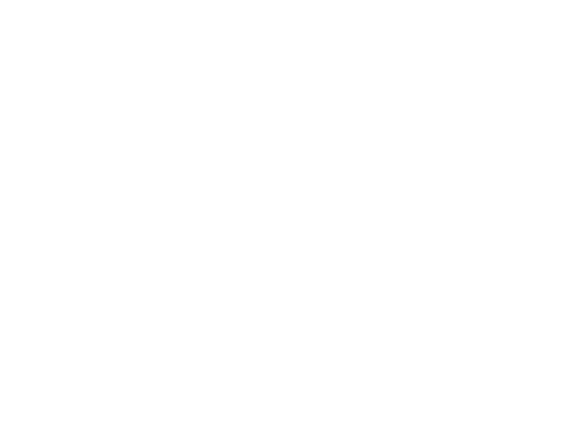

<IPython.core.display.Javascript object>


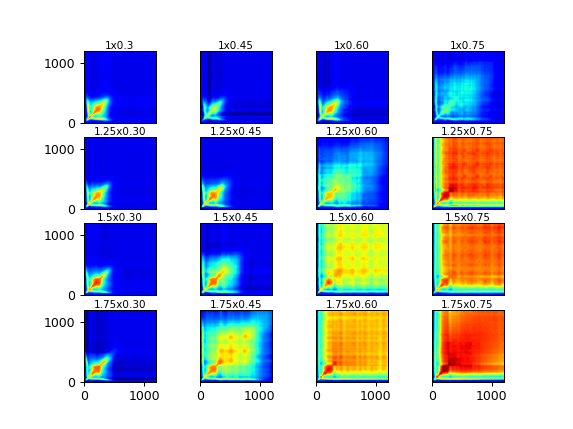

In [19]:
tups = [tup for tup in zip(paths_prepared, params_txt) if not re.match(r".*1,75x0,15", tup[0])]
tups = sorted(tups, key = lambda tup: tup[0])
# print(tups)
tups = [tups[i] for i in [12, 13, 14, 15] + list(range(0, 12))]

vmin = 0
vmax = 0

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)
    
    vmin = min(vmin, np.min(filtered))
    vmax = max(vmax, np.max(filtered))
    
    ax = fig.add_subplot(4, 4, i + 1)
    ax.set_title(param_txt, fontsize='small', va='top')
    if not i in [0, 4, 8, 12]:
        plt.yticks([])
    if not i in list(range(12, 16)):
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower')
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/FFxREC/ffxrecs.pdf', dpi=300, format='pdf')

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)

    ax = fig.add_subplot(4, 4, i + 1)
    ax.set_title(param_txt, fontsize='small', va='top')
    if not i in [0, 4, 8, 12]:
        plt.yticks([])
    if not i in list(range(12, 16)):
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/FFxREC/normalised-ffxrecs.pdf', dpi=300, format='pdf')

<IPython.core.display.Javascript object>


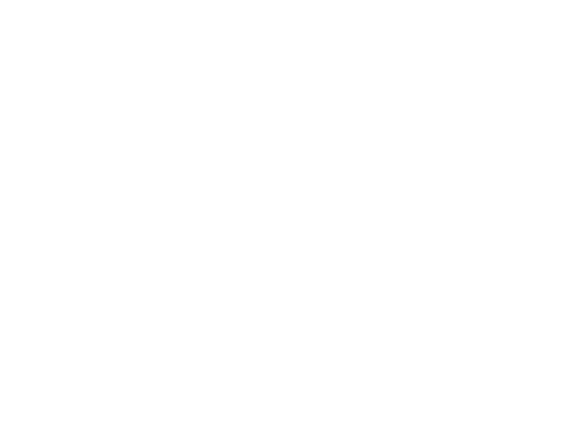

<IPython.core.display.Javascript object>


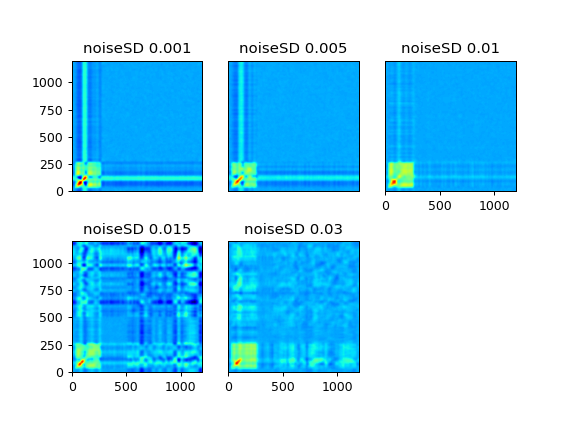

In [37]:
tups = [tup for tup in zip(paths_prepared, params_txt) if re.match(r".*noiseSD.*", tup[0])]
tups = [tups[i] for i in [0, 4, 3, 2, 1]]

vmin = 0
vmax = 0

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)
    
    vmin = min(vmin, np.min(filtered))
    vmax = max(vmax, np.max(filtered))

    ax = fig.add_subplot(230 + i + 1)
    ax.set_title(param_txt)
    if i != 0 and i != 3:
        plt.yticks([])
    if i < 2:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower')
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/cross-noiseSDs.pdf', dpi=300, format='pdf')

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)

    ax = fig.add_subplot(230 + i + 1)
    ax.set_title(param_txt)
    if i != 0 and i != 3:
        plt.yticks([])
    if i < 2:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/normalised-cross-noiseSDs.pdf', dpi=300, format='pdf')

<IPython.core.display.Javascript object>


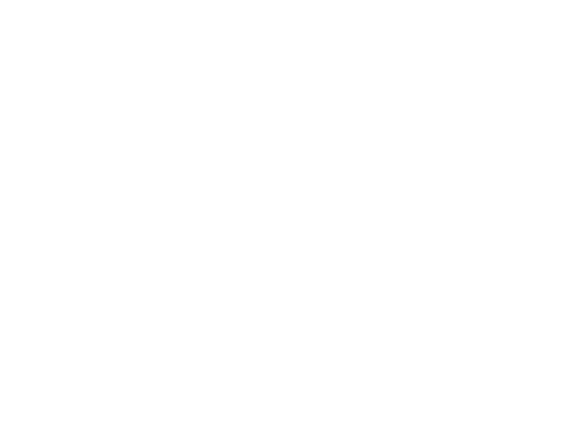

<IPython.core.display.Javascript object>


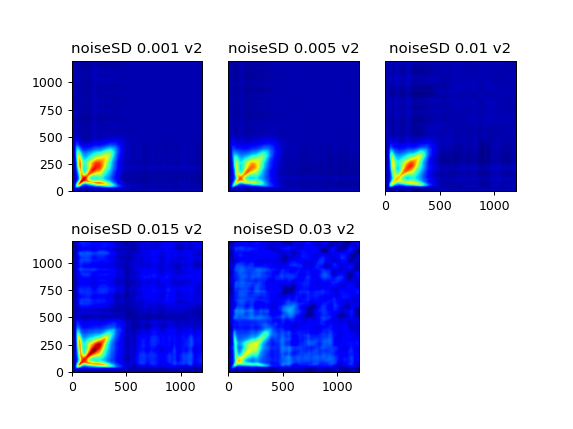

In [26]:
tups = [tup for tup in zip(paths_prepared, params_txt) if re.match(r".*noiseSD[0-9,_]*v2$", tup[0])]
tups = sorted(tups, key = lambda tup: tup[0])
tups = [tups[i] for i in [0, 1, 3, 2, 4]]

vmin = 0
vmax = 0

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)
    
    vmin = min(vmin, np.min(filtered))
    vmax = max(vmax, np.max(filtered))

    ax = fig.add_subplot(230 + i + 1)
    ax.set_title(param_txt)
    if i != 0 and i != 3:
        plt.yticks([])
    if i < 2:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower')
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/cross-noiseSDs-v2.pdf', dpi=300, format='pdf')

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)

    ax = fig.add_subplot(230 + i + 1)
    ax.set_title(param_txt)
    if i != 0 and i != 3:
        plt.yticks([])
    if i < 2:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/normalised-cross-noiseSDs-v2.pdf', dpi=300, format='pdf')

<IPython.core.display.Javascript object>


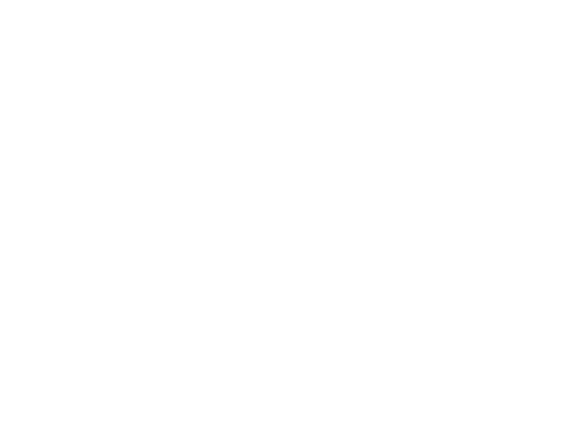

<IPython.core.display.Javascript object>


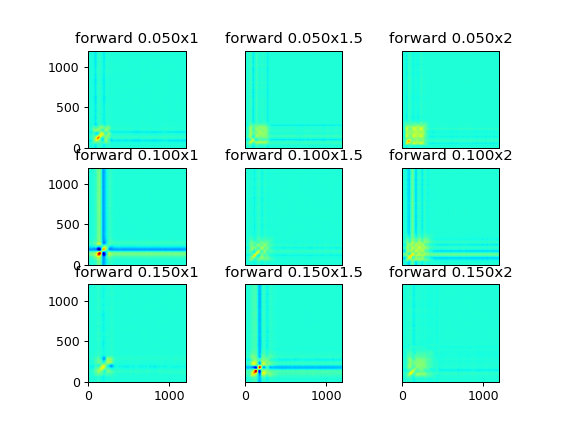

In [63]:
tups = [tup for tup in zip(paths_prepared, params_txt) if re.match(r".*forward.*", tup[0])]
tups = [tups[i] for i in [0, 8, 5, 6, 3, 1, 2, 7, 4]]

vmin = 0
vmax = 0

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)
    
    vmin = min(vmin, np.min(filtered))
    vmax = max(vmax, np.max(filtered))

    ax = fig.add_subplot(330 + i + 1)
    ax.set_title(param_txt)
    if not i in [0, 3, 6]:
        plt.yticks([])
    if not i in [6, 7, 8]:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower')
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/cross-forwards.pdf', dpi=300, format='pdf')

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)
    
    ax = fig.add_subplot(330 + i + 1)
    ax.set_title(param_txt)
    if not i in [0, 3, 6]:
        plt.yticks([])
    if not i in [6, 7, 8]:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/normalised-cross-forwards.pdf', dpi=300, format='pdf')

<IPython.core.display.Javascript object>


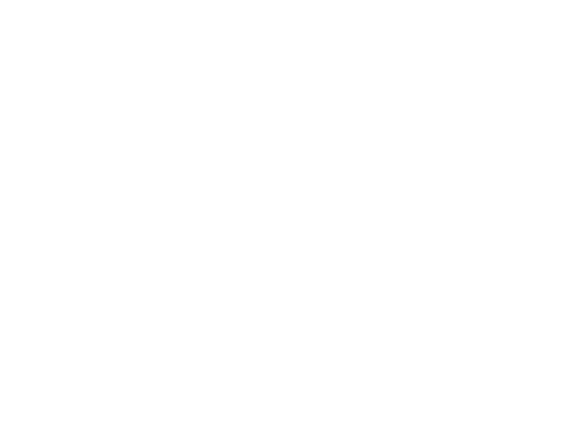

<IPython.core.display.Javascript object>


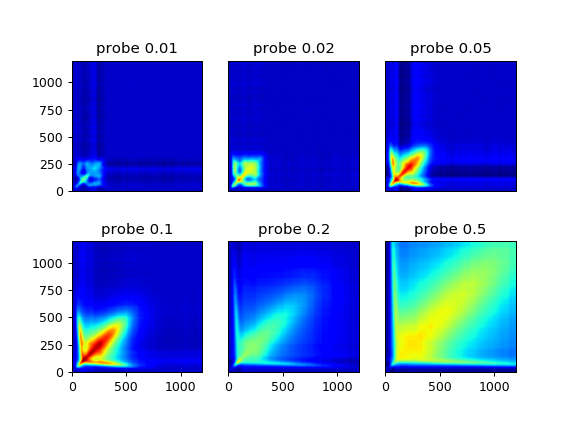

In [49]:
tups = [tup for tup in zip(paths_prepared, params_txt) if re.match(r".*probe.*", tup[0])]
tups = [tups[i] for i in [0, 4, 5, 1, 2, 3]]

vmin = 0
vmax = 0

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)
    
    vmin = min(vmin, np.min(filtered))
    vmax = max(vmax, np.max(filtered))

    ax = fig.add_subplot(230 + i + 1)
    ax.set_title(param_txt)
    if not i in [0, 3]:
        plt.yticks([])
    if not i in [3, 4, 5]:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower')
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/cross-probes.pdf', dpi=300, format='pdf')

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)

    ax = fig.add_subplot(230 + i + 1)
    ax.set_title(param_txt)
    if not i in [0, 3]:
        plt.yticks([])
    if not i in [3, 4, 5]:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/normalised-cross-probes.pdf', dpi=300, format='pdf')

<IPython.core.display.Javascript object>


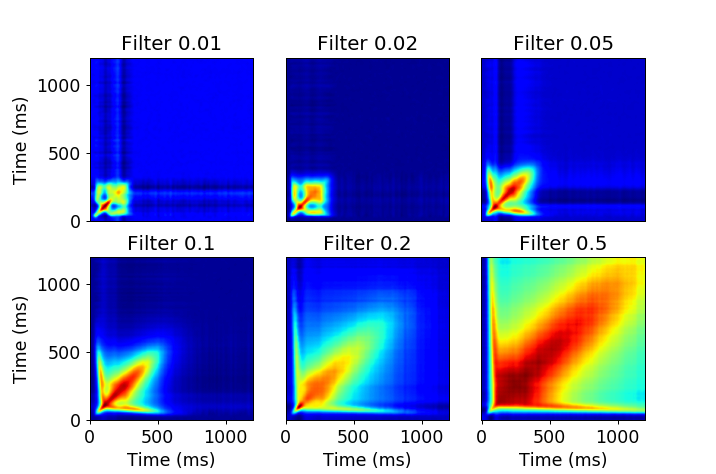

In [12]:
start_path = "/Users/s3182541/STSP/Decoding/data/sweep"
folders = ["probe_0,01", "probe_0,02", "probe_0,05", "probe_0,1", "probe_0,2", "probe_0,5"]

plt.close()
fig = plt.figure(figsize=[8.0, 5.3])

for i, folder in enumerate(folders):
    path = join(start_path, folder)
    
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)
    
    ax = fig.add_subplot(230 + i + 1)
    ax.set_title("Filter " + re.sub(r",", ".", re.sub(r"probe_", "", folder)))
    if not i in [0, 3]:
        plt.yticks([])
    else:
        plt.yticks([0, 500, 1000])
        plt.ylabel("Time (ms)")
        
    if not i in [3, 4, 5]:
        plt.xticks([])
    else:
        plt.xticks([0, 500, 1000])
        plt.xlabel("Time (ms)")
    ax.imshow(filtered, cmap='jet', origin='lower')

<IPython.core.display.Javascript object>


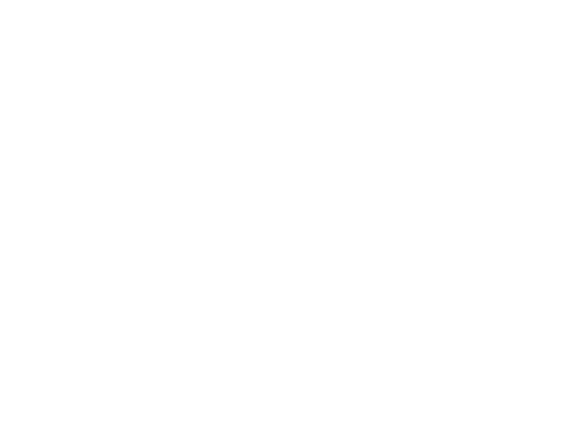

<IPython.core.display.Javascript object>


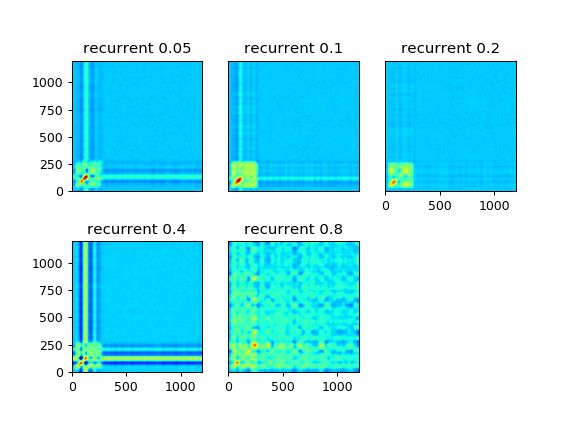

In [16]:
tups = [tup for tup in zip(paths_prepared, params_txt) if re.match(r".*recurrent[0-9,_]*$", tup[0])]
tups
tups = [tups[i] for i in [2, 3, 1, 0, 4]]

vmin = 0
vmax = 0

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)
    
    vmin = min(vmin, np.min(filtered))
    vmax = max(vmax, np.max(filtered))

    ax = fig.add_subplot(230 + i + 1)
    ax.set_title(param_txt)
    if i != 0 and i != 3:
        plt.yticks([])
    if i < 2:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower')
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/cross-recurrents-redone.pdf', dpi=300, format='pdf')

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)

    ax = fig.add_subplot(230 + i + 1)
    ax.set_title(param_txt)
    if i != 0 and i != 3:
        plt.yticks([])
    if i < 2:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/normalised-cross-recurrents-redone.pdf', dpi=300, format='pdf')

<IPython.core.display.Javascript object>


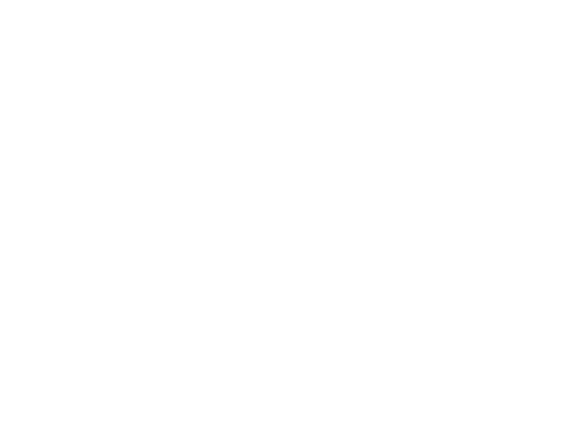

<IPython.core.display.Javascript object>


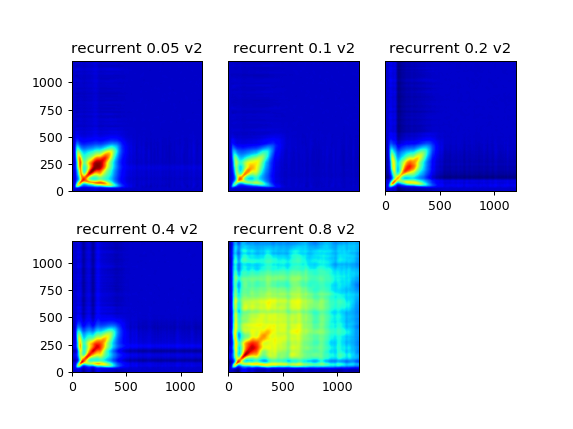

In [24]:
tups = [tup for tup in zip(paths_prepared, params_txt) if re.match(r".*recurrent[0-9,_]*v2$", tup[0])]
tups = sorted(tups, key = lambda tup: tup[0])

vmin = 0
vmax = 0

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)
    
    vmin = min(vmin, np.min(filtered))
    vmax = max(vmax, np.max(filtered))

    ax = fig.add_subplot(230 + i + 1)
    ax.set_title(param_txt)
    if i != 0 and i != 3:
        plt.yticks([])
    if i < 2:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower')
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/cross-recurrents-v2.pdf', dpi=300, format='pdf')

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)

    ax = fig.add_subplot(230 + i + 1)
    ax.set_title(param_txt)
    if i != 0 and i != 3:
        plt.yticks([])
    if i < 2:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/normalised-cross-recurrents-v2.pdf', dpi=300, format='pdf')

In [17]:
bin_width = np.pi / 6
angspace = np.arange(-np.pi, np.pi, bin_width)

for path in paths_prepared:
# for path in ['/Users/s3182541/STSP/Decoding/data/testmodels/model4']:
    file = join(path, "cos_amp.npy")
    
    if not os.path.exists(file):
        data = np.load(join(path, "data.npy"))
        angles = np.load(join(path, "angles.npy"))

        cos_amp, _ = wolff.similarity_p(data, angles, angspace, bin_width, 40)

        cos_amp = np.mean(cos_amp, 0)
        np.save(file, cos_amp)

360


<IPython.core.display.Javascript object>


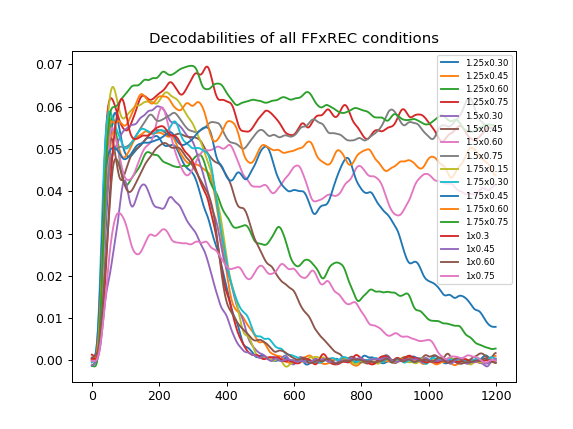

/Users/s3182541/STSP/Decoding/data/FFxREC/1,25x0,30 1.25x0.30
/Users/s3182541/STSP/Decoding/data/FFxREC/1,25x0,45 1.25x0.45
/Users/s3182541/STSP/Decoding/data/FFxREC/1,25x0,60 1.25x0.60
/Users/s3182541/STSP/Decoding/data/FFxREC/1,25x0,75 1.25x0.75
/Users/s3182541/STSP/Decoding/data/FFxREC/1,5x0,30 1.5x0.30
/Users/s3182541/STSP/Decoding/data/FFxREC/1,5x0,45 1.5x0.45
/Users/s3182541/STSP/Decoding/data/FFxREC/1,5x0,60 1.5x0.60
/Users/s3182541/STSP/Decoding/data/FFxREC/1,5x0,75 1.5x0.75
/Users/s3182541/STSP/Decoding/data/FFxREC/1,75x0,15 1.75x0.15
/Users/s3182541/STSP/Decoding/data/FFxREC/1,75x0,30 1.75x0.30
/Users/s3182541/STSP/Decoding/data/FFxREC/1,75x0,45 1.75x0.45
/Users/s3182541/STSP/Decoding/data/FFxREC/1,75x0,60 1.75x0.60
/Users/s3182541/STSP/Decoding/data/FFxREC/1,75x0,75 1.75x0.75
/Users/s3182541/STSP/Decoding/data/FFxREC/1x0,3 1x0.3
/Users/s3182541/STSP/Decoding/data/FFxREC/1x0,45 1x0.45
/Users/s3182541/STSP/Decoding/data/FFxREC/1x0,60 1x0.60
/Users/s3182541/STSP/Decoding/data/F

In [22]:
plt.close()

plt.title("Decodabilities of all FFxREC conditions")

for path, param_txt in zip(sorted(paths_prepared), sorted(params_txt)):
    cos_amp = np.load(join(path, "cos_amp.npy"))
    plt.plot(gaussian_filter(cos_amp, sigma=8), label=param_txt)
    
plt.legend(fontsize='x-small')
plt.savefig('/Users/s3182541/STSP/Decoding/data/FFxREC/decodabilities.pdf', dpi=300, format='pdf')
plt.show()

<IPython.core.display.Javascript object>


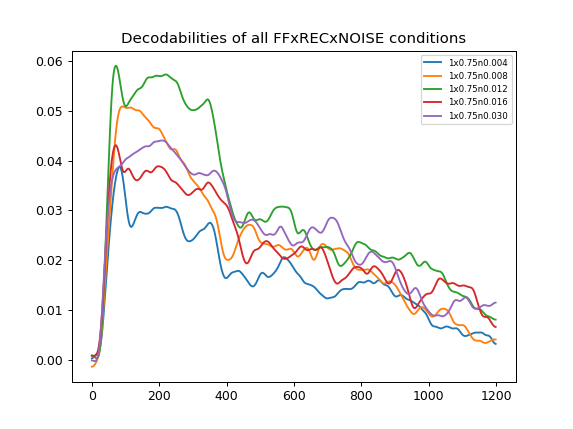

In [16]:
plt.close()

plt.title("Decodabilities of all FFxRECxNOISE conditions")

for path, param_txt in list(zip(paths_prepared, params_txt))[20:25]:
    cos_amp = np.load(join(path, "cos_amp.npy"))
    plt.plot(gaussian_filter(cos_amp, sigma=8), label=param_txt)
    
plt.legend(fontsize='x-small')
plt.savefig('/Users/s3182541/STSP/Decoding/data/FFxRECxNOISE/decodabilities1x0,75.pdf', dpi=300, format='pdf')
plt.show()

<IPython.core.display.Javascript object>


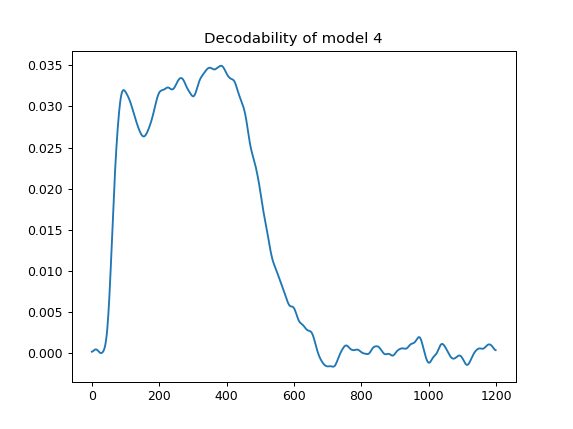

In [20]:
plt.close()

plt.title("Decodability of model 4")

cos_amp = np.load(join('/Users/s3182541/STSP/Decoding/data/testmodels/model4', "cos_amp.npy"))
plt.plot(gaussian_filter(cos_amp, sigma=8), label='1.5x0.3n0.01')

plt.savefig('/Users/s3182541/STSP/Decoding/data/testmodels/model4/decodability.pdf', dpi=300, format='pdf')
plt.show()

<IPython.core.display.Javascript object>


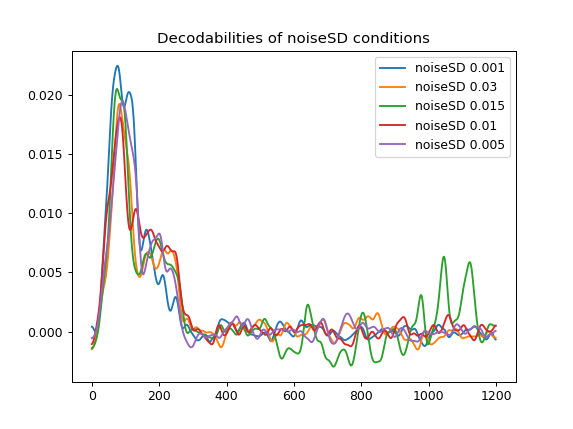

In [10]:
plt.close()

plt.title("Decodabilities of noiseSD conditions")

for path, param_txt in zip(paths_prepared, params_txt):
    if re.match(r".*noiseSD.*", path):
        cos_amp = np.load(join(path, "cos_amp.npy"))
        plt.plot(gaussian_filter(cos_amp, sigma=8), label=param_txt)
    
plt.legend()
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/noiseSDs.pdf', dpi=300, format='pdf')

<IPython.core.display.Javascript object>


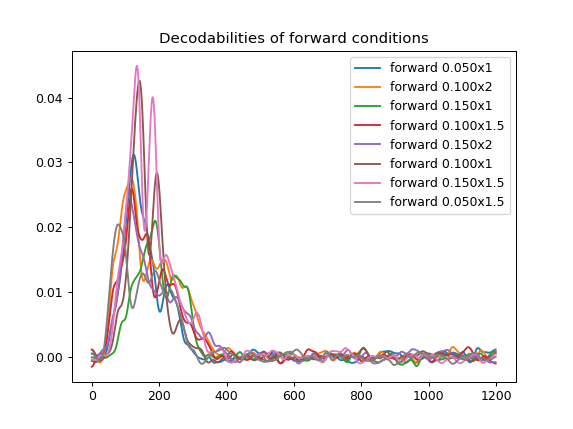

In [12]:
plt.close()

plt.title("Decodabilities of forward conditions")

for path, param_txt in zip(paths_prepared, params_txt):
    if re.match(r".*forward.*", path):
        cos_amp = np.load(join(path, "cos_amp.npy"))
        plt.plot(gaussian_filter(cos_amp, sigma=8), label=param_txt)
    
plt.legend()
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/forwards.pdf', dpi=300, format='pdf')

<IPython.core.display.Javascript object>


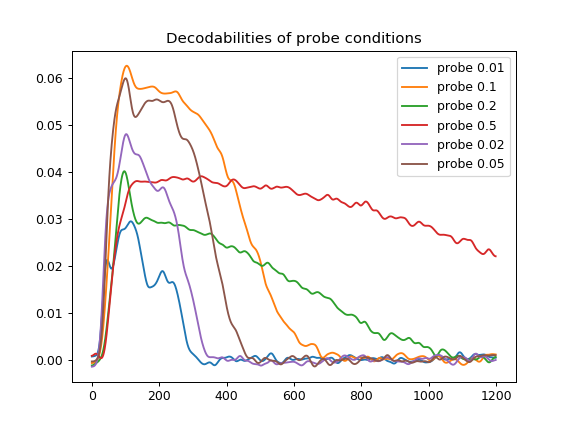

In [13]:
plt.close()

plt.title("Decodabilities of probe conditions")

for path, param_txt in zip(paths_prepared, params_txt):
    if re.match(r".*probe.*", path):
        cos_amp = np.load(join(path, "cos_amp.npy"))
        plt.plot(gaussian_filter(cos_amp, sigma=8), label=param_txt)
    
plt.legend()
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/probes.pdf', dpi=300, format='pdf')

<IPython.core.display.Javascript object>


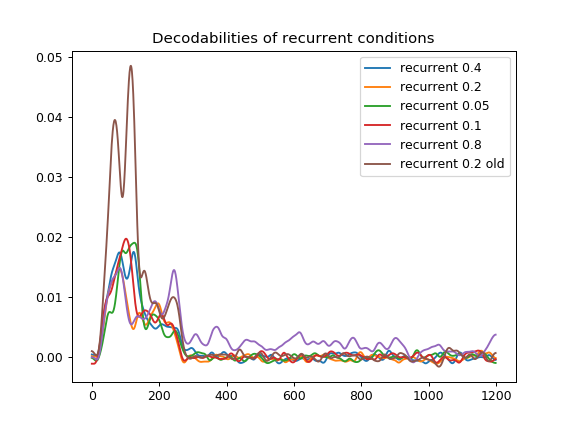

In [19]:
plt.close()

plt.title("Decodabilities of recurrent conditions")

for path, param_txt in zip(paths_prepared, params_txt):
    if re.match(r".*recurrent[0-9,_]*(old)?$", path):
        cos_amp = np.load(join(path, "cos_amp.npy"))
        plt.plot(gaussian_filter(cos_amp, sigma=8), label=param_txt)
    
plt.legend()
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/recurrents.pdf', dpi=300, format='pdf')

<IPython.core.display.Javascript object>


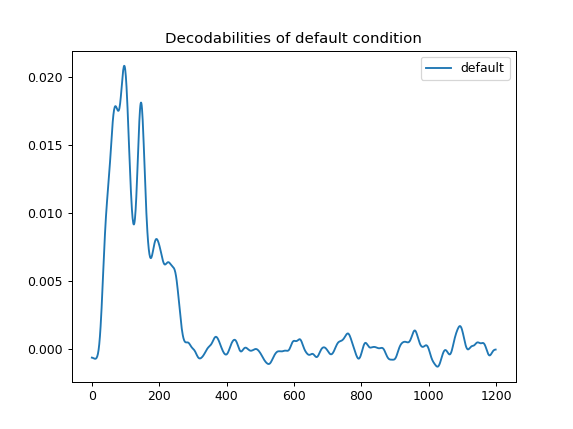

In [15]:
plt.close()

plt.title("Decodabilities of default condition")

for path, param_txt in zip(paths_prepared, params_txt):
    if re.match(r".*default.*", path):
        cos_amp = np.load(join(path, "cos_amp.npy"))
        plt.plot(gaussian_filter(cos_amp, sigma=8), label=param_txt)
    
plt.legend()
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/default.pdf', dpi=300, format='pdf')